# Coin Classification with CNN (PyTorch)

This notebook uses the **coin detection dataset** from the Computer Vision assignment (cropped coin images in `build/training_data/`). It implements:

1. **Custom small CNN**: 3–4 convolutional layers + 2 fully connected layers  
2. **ResNet18** from `torchvision.models` (transfer learning)  
3. **Comparison** of accuracy and training behavior  

**Setup**: Run locally or on Google Colab (GPU recommended). If using Colab, upload the project or set `DATA_ROOT` to your dataset path.

**Dependencies**: `torch`, `torchvision`, `Pillow`, `matplotlib`, `scikit-learn`. On Colab: *Runtime → Change runtime type → GPU* then run the cells below.

In [15]:
import os
import random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
REPO_ROOT = Path(os.getcwd())
if not (REPO_ROOT / "build" / "training_data_2").exists():
    REPO_ROOT = Path("/content/coin_counter_cpp")
DATA_ROOT = REPO_ROOT / "build" / "training_data_2"
CLASS_DIRS = ["20cent", "10cent", "1euro", "1cent", "2cent", "5cent"]
NUM_CLASSES = len(CLASS_DIRS)
CLASS_NAMES = ["20 cent", "10 cent", "1 euro", "1 cent", "2 cent", "5 cent"]
LABEL_TO_ID = {name: i for i, name in enumerate(CLASS_DIRS)}
print(f"DATA_ROOT = {DATA_ROOT.resolve()}")
print(f"Exists: {DATA_ROOT.exists()}")
print(f"Classes: {CLASS_NAMES}")

DATA_ROOT = /home/david/master upm/car-uav/coin_counter_simple/coin_counter_cpp/build/training_data_2
Exists: True
Classes: ['20 cent', '10 cent', '1 euro', '1 cent', '2 cent', '5 cent']


In [17]:
import json

CROP_SIZE = 150  # bounding box 150x150 px centered on each label

def extract_crop(img_array, cx, cy, crop_size, h, w):
    """Extract a crop_size x crop_size region centered at (cx, cy). Pad with zeros if out of bounds."""
    half = crop_size // 2
    x1, y1 = cx - half, cy - half
    x2, y2 = cx + half, cy + half
    src_x1, src_y1 = max(0, x1), max(0, y1)
    src_x2, src_y2 = min(w, x2), min(h, y2)
    dst_x1, dst_y1 = src_x1 - x1, src_y1 - y1
    crop_h, crop_w = src_y2 - src_y1, src_x2 - src_x1
    canvas = np.zeros((crop_size, crop_size, 3), dtype=np.uint8)
    if crop_h > 0 and crop_w > 0:
        canvas[dst_y1:dst_y1 + crop_h, dst_x1:dst_x1 + crop_w] = img_array[
            src_y1:src_y2, src_x1:src_x2
        ]
    return Image.fromarray(canvas, mode="RGB")

class CoinDatasetFromCenters(Dataset):
    """Build dataset from training_data_2: full images + JSON labels; each sample = 150x150 crop at label center."""
    def __init__(self, root, label_to_id, crop_size=150, transform=None):
        self.root = Path(root)
        self.transform = transform
        self.crop_size = crop_size
        self.label_to_id = label_to_id
        self.samples = []
        images_dir = self.root / "images"
        labels_dir = self.root / "labels"
        if not images_dir.is_dir() or not labels_dir.is_dir():
            return
        for label_path in sorted(labels_dir.glob("*.json")):
            with open(label_path, "r") as f:
                data = json.load(f)
            image_path = images_dir / data["imagePath"]
            if not image_path.exists():
                continue
            for shape in data.get("shapes", []):
                label_name = shape.get("label")
                center = shape.get("center")
                if label_name not in self.label_to_id or not center:
                    continue
                cx, cy = int(center[0]), int(center[1])
                self.samples.append((str(image_path), cx, cy, self.label_to_id[label_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, cx, cy, label = self.samples[idx]
        img = Image.open(image_path).convert("RGB")
        arr = np.array(img)
        h, w = arr.shape[:2]
        crop = extract_crop(arr, cx, cy, self.crop_size, h, w)
        if self.transform:
            crop = self.transform(crop)
        return crop, label

full_ds = CoinDatasetFromCenters(DATA_ROOT, LABEL_TO_ID, crop_size=CROP_SIZE)
print(f"Total samples (150x150 crops from label centers): {len(full_ds)}")
if len(full_ds) == 0:
    raise FileNotFoundError(f"No labels/images in {DATA_ROOT}. Check build/training_data_2/images and labels.")

Total samples (150x150 crops from label centers): 600


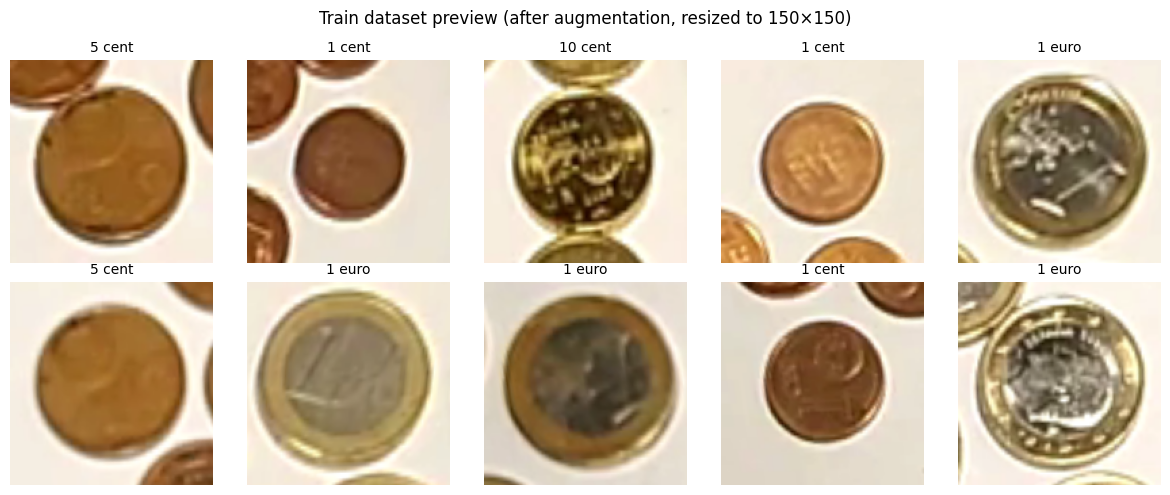

In [18]:
# Preview 10 random samples from train_ds after data augmentation
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
indices = random.sample(range(len(full_ds)), 10)
for i, ax in enumerate(axes.flat):
    img, label = full_ds[indices[i]]
    ax.imshow(img)
    ax.set_title(CLASS_NAMES[label], fontsize=10)
    ax.axis("off")
plt.suptitle("Train dataset preview (after augmentation, resized to 150×150)", fontsize=12)
plt.tight_layout()
plt.show()

In [28]:
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.01),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

n_total = len(full_ds)
n_val = max(1, int(0.2 * n_total))
n_train = n_total - n_val
train_ds_raw, val_ds_raw = random_split(full_ds, [n_train, n_val], generator=torch.Generator().manual_seed(42))
print(f"Split: {n_total} total → {n_train} train, {n_val} val (80/20)")

class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        img, label = self.subset.dataset[self.subset.indices[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label

train_ds = SubsetWithTransform(train_ds_raw, train_transform)
val_ds = SubsetWithTransform(val_ds_raw, val_transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
print(f"Train: {len(train_ds)}, Val: {len(val_ds)}")

Split: 600 total → 480 train, 120 val (80/20)
Train: 480, Val: 120


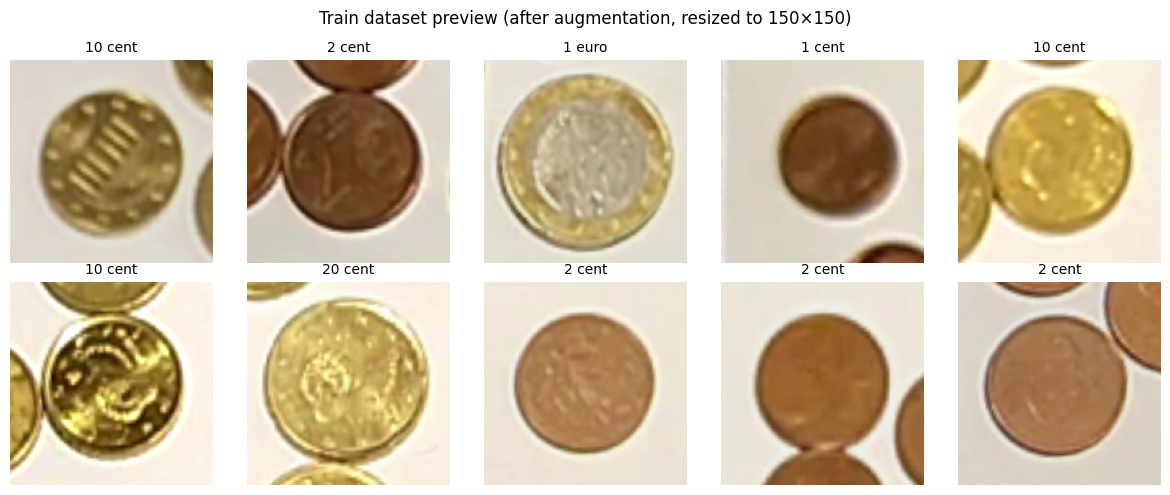

In [29]:
# Preview 10 random samples from train_ds after data augmentation
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
indices = random.sample(range(len(train_ds)), 10)
for i, ax in enumerate(axes.flat):
    img_tensor, label = train_ds[indices[i]]
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_np * std + mean
    img_np = np.clip(img_np, 0, 1)
    ax.imshow(img_np)
    ax.set_title(CLASS_NAMES[label], fontsize=10)
    ax.axis("off")
plt.suptitle("Train dataset preview (after augmentation, resized to 150×150)", fontsize=12)
plt.tight_layout()
plt.show()

In [30]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model_cnn = SmallCNN(num_classes=NUM_CLASSES).to(device)
print(model_cnn)

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, aff

In [31]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total

In [32]:
EPOCHS_CNN = 30
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=1e-3)
scheduler_cnn = optim.lr_scheduler.StepLR(optimizer_cnn, step_size=10, gamma=0.5)

history_cnn = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
for epoch in range(EPOCHS_CNN):
    tl, ta = train_epoch(model_cnn, train_loader, criterion, optimizer_cnn, device)
    vl, va = evaluate(model_cnn, val_loader, criterion, device)
    scheduler_cnn.step()
    history_cnn["train_loss"].append(tl)
    history_cnn["train_acc"].append(ta)
    history_cnn["val_loss"].append(vl)
    history_cnn["val_acc"].append(va)
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}  train loss={tl:.4f} acc={ta:.4f}  val loss={vl:.4f} acc={va:.4f}")

best_val_acc_cnn = max(history_cnn["val_acc"])
print(f"\nBest validation accuracy (Small CNN): {best_val_acc_cnn:.4f}")

Epoch   1  train loss=1.3420 acc=0.4917  val loss=1.3474 acc=0.4000
Epoch   5  train loss=0.5819 acc=0.7458  val loss=0.9679 acc=0.4750
Epoch  10  train loss=0.4318 acc=0.8208  val loss=0.7099 acc=0.6583
Epoch  15  train loss=0.3668 acc=0.8479  val loss=0.2833 acc=0.8750
Epoch  20  train loss=0.2752 acc=0.9000  val loss=0.4582 acc=0.7333
Epoch  25  train loss=0.2263 acc=0.9292  val loss=0.2456 acc=0.9083
Epoch  30  train loss=0.1908 acc=0.9500  val loss=0.2447 acc=0.9083

Best validation accuracy (Small CNN): 0.9500


In [33]:
model_resnet = resnet18(weights=None)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, NUM_CLASSES)
model_resnet = model_resnet.to(device)

optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=1e-3)
scheduler_resnet = optim.lr_scheduler.StepLR(optimizer_resnet, step_size=10, gamma=0.5)
history_resnet = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

In [34]:
EPOCHS_RESNET = 30
for epoch in range(EPOCHS_RESNET):
    tl, ta = train_epoch(model_resnet, train_loader, criterion, optimizer_resnet, device)
    vl, va = evaluate(model_resnet, val_loader, criterion, device)
    scheduler_resnet.step()
    history_resnet["train_loss"].append(tl)
    history_resnet["train_acc"].append(ta)
    history_resnet["val_loss"].append(vl)
    history_resnet["val_acc"].append(va)
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}  train loss={tl:.4f} acc={ta:.4f}  val loss={vl:.4f} acc={va:.4f}")

best_val_acc_resnet = max(history_resnet["val_acc"])
print(f"\nBest validation accuracy (ResNet18): {best_val_acc_resnet:.4f}")

Epoch   1  train loss=0.8256 acc=0.6833  val loss=10.1763 acc=0.2417
Epoch   5  train loss=0.0974 acc=0.9708  val loss=0.1257 acc=0.9667
Epoch  10  train loss=0.0951 acc=0.9708  val loss=0.1130 acc=0.9667
Epoch  15  train loss=0.0139 acc=0.9938  val loss=0.0615 acc=0.9833
Epoch  20  train loss=0.0080 acc=0.9979  val loss=0.0498 acc=0.9833
Epoch  25  train loss=0.0027 acc=1.0000  val loss=0.0723 acc=0.9833
Epoch  30  train loss=0.0030 acc=1.0000  val loss=0.0757 acc=0.9833

Best validation accuracy (ResNet18): 0.9917


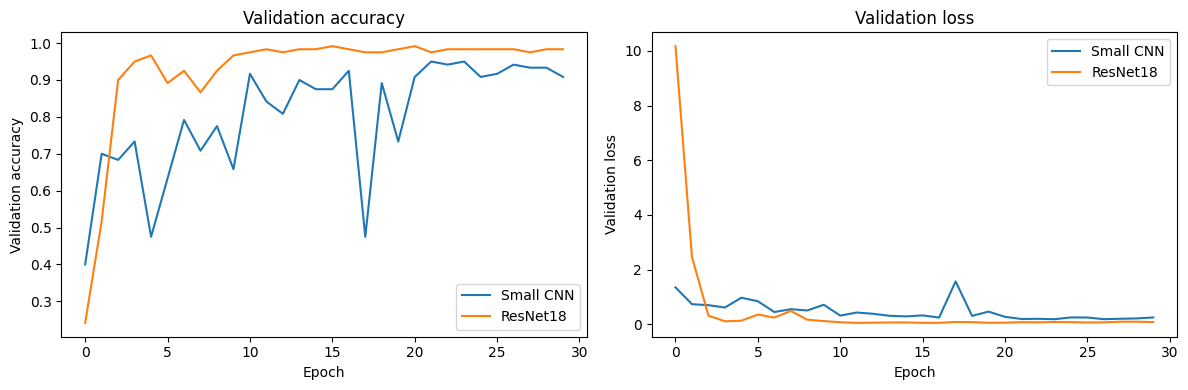


--- Summary ---
Small CNN  best val accuracy: 0.9500
ResNet18   best val accuracy: 0.9917


In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history_cnn["val_acc"], label="Small CNN")
axes[0].plot(history_resnet["val_acc"], label="ResNet18")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Validation accuracy")
axes[0].legend()
axes[0].set_title("Validation accuracy")
axes[1].plot(history_cnn["val_loss"], label="Small CNN")
axes[1].plot(history_resnet["val_loss"], label="ResNet18")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation loss")
axes[1].legend()
axes[1].set_title("Validation loss")
plt.tight_layout()
plt.show()

print("\n--- Summary ---")
print(f"Small CNN  best val accuracy: {best_val_acc_cnn:.4f}")
print(f"ResNet18   best val accuracy: {best_val_acc_resnet:.4f}")

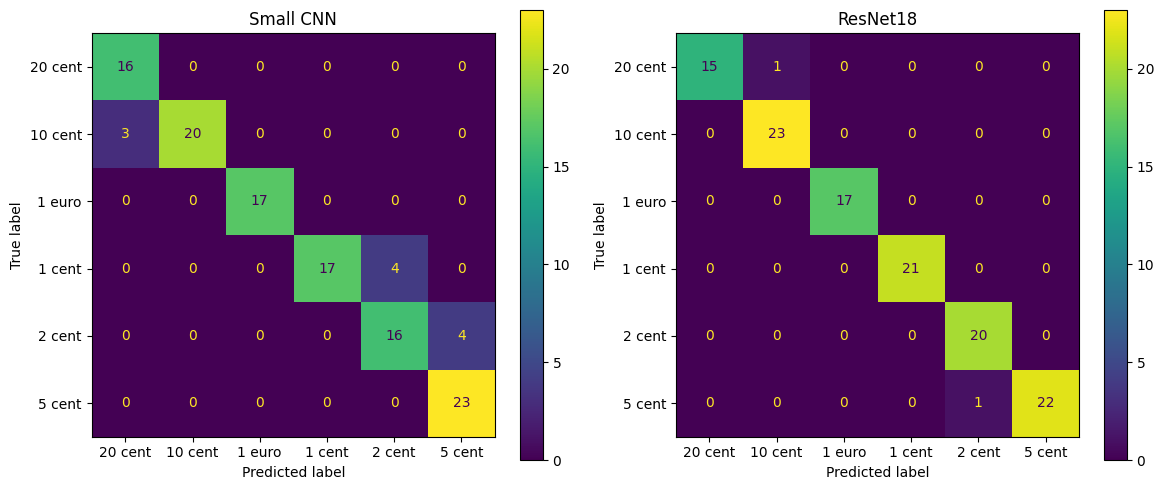

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

@torch.no_grad()
def get_predictions(model, loader, device):
    model.eval()
    all_pred, all_true = [], []
    for x, y in loader:
        x = x.to(device)
        pred = model(x).argmax(dim=1).cpu().numpy()
        all_pred.extend(pred)
        all_true.extend(y.numpy())
    return np.array(all_true), np.array(all_pred)

y_true, y_pred_cnn = get_predictions(model_cnn, val_loader, device)
y_true, y_pred_resnet = get_predictions(model_resnet, val_loader, device)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred_cnn), display_labels=CLASS_NAMES).plot(ax=axes[0])
axes[0].set_title("Small CNN")
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred_resnet), display_labels=CLASS_NAMES).plot(ax=axes[1])
axes[1].set_title("ResNet18")
plt.tight_layout()
plt.show()

In [37]:
torch.save({"model_state": model_cnn.state_dict(), "class_names": CLASS_NAMES}, "coin_cnn.pt")
torch.save({"model_state": model_resnet.state_dict(), "class_names": CLASS_NAMES}, "coin_resnet18.pt")

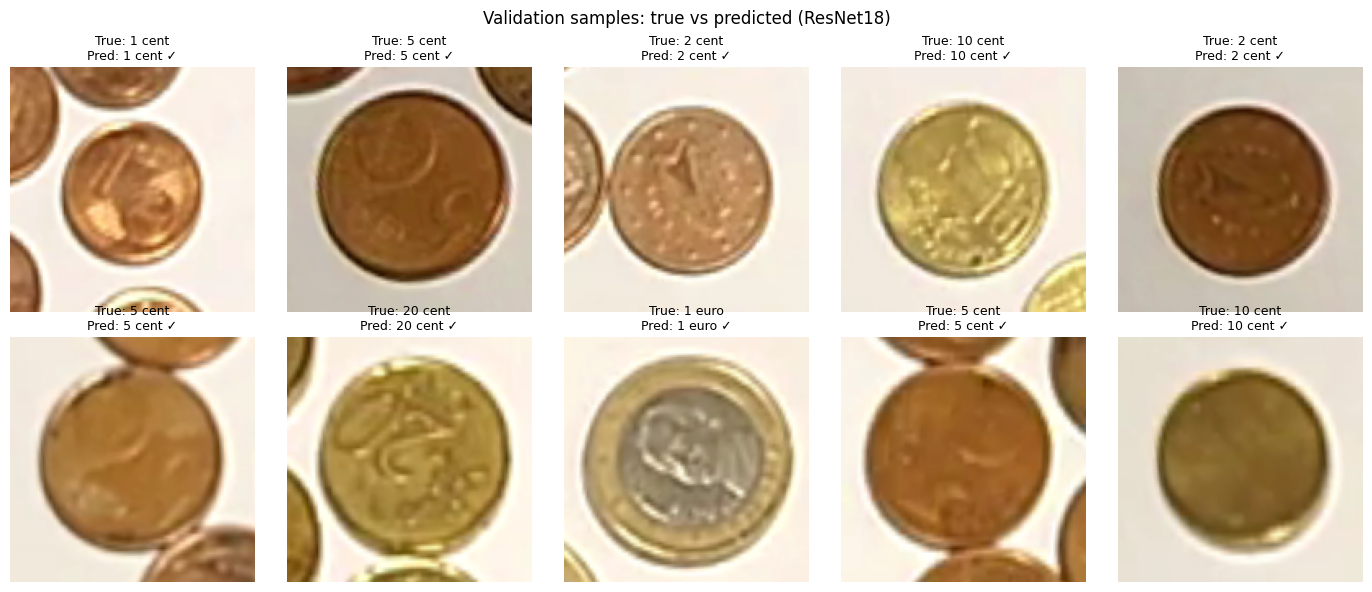

In [38]:
model_resnet.eval()
val_subset = val_ds.subset  # access the underlying subset to get full_ds indices
n_show = min(10, len(val_ds))
indices = random.sample(range(len(val_ds)), n_show)

fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.flat
for i, idx in enumerate(indices):
    full_ds_idx = val_subset.indices[idx]
    raw_img, true_label = full_ds[full_ds_idx]
    img_tensor, _ = val_ds[idx]
    with torch.no_grad():
        pred = model_resnet(img_tensor.unsqueeze(0).to(device)).argmax(1).item()
    axes[i].imshow(raw_img)
    correct = "✓" if pred == true_label else "✗"
    axes[i].set_title(f"True: {CLASS_NAMES[true_label]}\nPred: {CLASS_NAMES[pred]} {correct}", fontsize=9)
    axes[i].axis("off")
plt.suptitle("Validation samples: true vs predicted (ResNet18)", fontsize=12)
plt.tight_layout()
plt.show()